In [1]:
%matplotlib inline

from matplotlib import pyplot as pl
from scipy.integrate import odeint
import numpy as np

# A solar system simulator demonstration in python

This notebook shows a simple solar system simulator (or in reality any general N-body gravitational interaction simulator) using python.

In [2]:
def grav(x, t, masses):
    """
    Coupled differential equations for computing the gravitational
    attraction between n-bodies.

    Args:
        x (:class:`numpy.ndarray`): an array containing the 3D position and velocity vectors of
            each of then bodies, e.g. for [x1, y1, z1, vx1, vy1, vz1, ... ]
        t (float): a time
        masses (list): a list of masses multiplied by G for each bodies, in units using AUs and
           days 
    """

    # number of bodies
    N = len(masses)

    Y = np.zeros(6*N)
    # coupled differential equations
    # x = [x,y,z,vx,vy,vz]

    # 3D orbits
    for i in range(N):
        # dx/dt = v
        Y[6*i:6*i+3] = x[6*i+3:6*i+6]

        for j in range(N):
            if i != j:
                r = np.sqrt(np.sum((x[6*j:6*j+3]-x[6*i:6*i+3])**2))

                # dv/dt = a  (a = F/m) (F = GMm|x2-x1|/r^3)
                Y[6*j+3:6*j+6] += masses[i]*(x[6*i:6*i+3]-x[6*j:6*j+3])/r**3         

    return Y

To initialise the solar system (positions and velocities), in this case just the Earth/Moon system and Sun, we can use the JPL ephemeris values (e.g., those found [here](http://www.astro.gla.ac.uk/honours/labs/solar_system/JPL%20coordinates/)). We also need masses of the planets, which are given as ratios to the mass of the Sun, which in turn is defined though the [Gaussian gravitational constant](https://en.wikipedia.org/wiki/Gaussian_gravitational_constant), [here](http://www.astro.gla.ac.uk/honours/labs/solar_system/astro_constants.html).

In [3]:
# set masses (Earth and Sun)
GM = [(0.01720209895)**2/328900.56, (0.01720209895)**2]  # see http://www.astro.gla.ac.uk/honours/labs/solar_system/astro_constants.html

# set up the initial position of the Earth in units of AU and AU/day:
X = np.zeros(2*6)

# Earth's initial position and velocity
X[0] = -1.756895992827094E-01
X[1] =  9.659716383076408E-01
X[2] = 2.050240276128469E-04
X[3] = -1.722463621150023E-02
X[4] = -3.020684839068507E-03
X[5] = -7.003389133678563E-08

# Sun's initial position and velocity
X[6] = -7.139147132286038E-03
X[7] = -2.792019830280757E-03
X[8] = 2.061825715444439E-04
X[9] = 5.374261407019511E-06
X[10] = -7.410966744915032E-06
X[11] = -9.422889366172143E-08

# set the timestamps at which the solver will work (note that this does not use adaptive step sizes)
times = np.arange(0., 3650.) # ten years with one step per day

y, infodict = odeint(grav, X, times, args=(GM,), full_output=True)


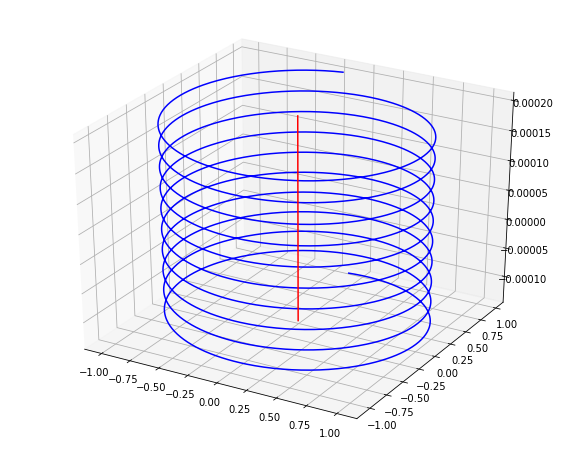

In [4]:
from mpl_toolkits.mplot3d import Axes3D

fig = pl.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(y[:,0], y[:,1], y[:,2], 'b')
ax.plot(y[:,6], y[:,7], y[:,8], 'r')

Let's do all the planets!

In [5]:
import requests
from six import StringIO
import re
from collections import OrderedDict

In [6]:
# read in the JPL ephemeris data
baseurl = 'http://www.astro.gla.ac.uk/honours/labs/solar_system/JPL%20coordinates/{}'

jplfiles = OrderedDict() # use ordered dictionary so that planets are in the right order
jplfiles['Sun'] = 'sun.txt'
jplfiles['Mercury'] = 'mercury.txt'
jplfiles['Venus'] = 'venus.txt'
jplfiles['Earth'] = 'earthmoon.txt'
jplfiles['Mars'] = 'mars.txt'
jplfiles['Jupiter'] = 'jupiter.txt'
jplfiles['Saturn'] = 'saturn.txt'
jplfiles['Uranus'] = 'uranus.txt'
jplfiles['Neptune'] = 'neptune.txt'
jplfiles['Pluto'] = 'pluto.txt'

jpldata = OrderedDict()
for oname, ofile in jplfiles.items():
    jpleph = requests.get(baseurl.format(ofile))
    content = re.findall(r'\$\$SOE(.*?)\$\$EOE', str(jpleph.content), flags=re.U|re.S|re.M)[0]
    fp = StringIO(content)
    data = np.loadtxt(fp, delimiter=',', usecols=(0, 2, 3, 4, 5, 6, 7))
    jpldata[oname] = data

In [7]:
# mass ratios compared to the Sun
massratios = OrderedDict()
massratios['Sun'] =     1.
massratios['Mercury'] = 1./6023600.
massratios['Venus'] =   1./408523.71
massratios['Earth'] =   1./328900.56 # Earth + Moon system
massratios['Mars'] =    1./3098708.
massratios['Jupiter'] = 1./1047.3486
massratios['Saturn'] =  1./3497.898
massratios['Uranus'] =  1./22902.98
massratios['Neptune'] = 1./19412.24
massratios['Pluto'] =   1./1.35e8

# Gaussian gravitational constant
k = 0.01720209895 # (AU^3/d^2)^1/2

# G*M
GM = np.array(massratios.values())*k**2

In [8]:
# set up the initial position of the Earth in units of AU and AU/day:
X = np.zeros(len(GM)*6)
for i, planet in enumerate(jpldata.keys()):
    X[6*i:6*(i+1)] = jpldata[planet][0,1:]

times = jpldata['Sun'][:,0]-jpldata['Sun'][0,0]

y, infodict = odeint(grav, X, times, args=(GM,), full_output=True)

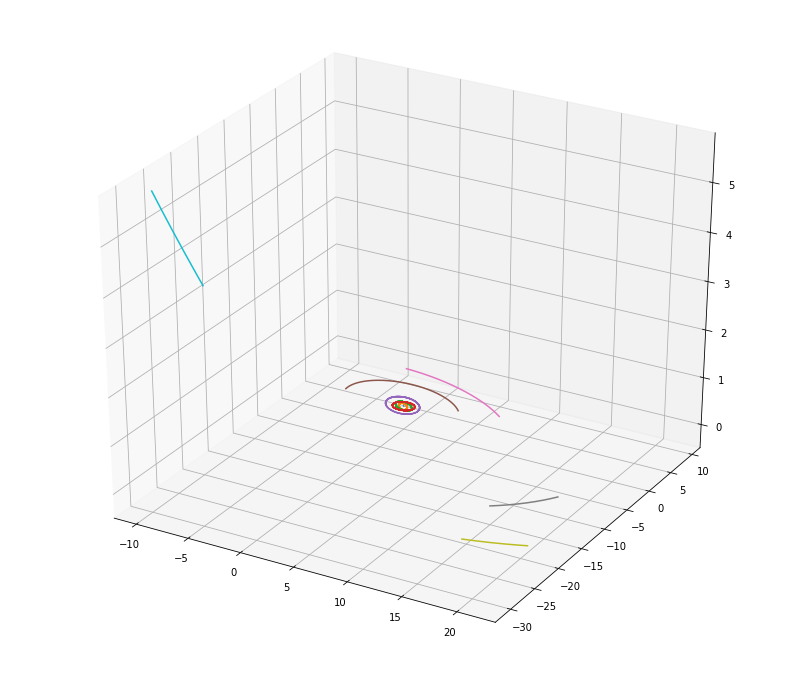

In [9]:
fig = pl.figure(figsize=(14,12))
ax = fig.add_subplot(111, projection='3d')
for i in range(len(GM)):
    ax.plot(y[:,6*i], y[:,6*i+1], y[:,6*i+2])